<a href="https://colab.research.google.com/github/BillWENZE/Mgtf_424_Homework/blob/main/SVM_Self_Practice_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machine for Trading

**Background:**

Suppose you are working as an analyst at an investment bank. Your manager asked you to implement a new trading algorithm for Apple stock.

You decided to use the following indicators:

* Average True Range
* Commodity Channel Index
* Relative Strength Index
* Bollinger Bands
* On Balance Volume
* Momentum
* MACD


Your training set includes data up to 03/18/2022. You will apply time series cross-validation to tune the hyper-parameter. Test the model on the last 30 trading days.

**Objective**
* Use SVM Classification on financial data
* Use Randomized Search
* Use Time Series Cross Validation
* Evaluate trading model

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4239    0  4239    0     0  23949      0 --:--:-- --:--:-- --:--:-- 23949
100  517k  100  517k    0     0   871k      0 --:--:-- --:--:-- --:--:--  871k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4243    0  4243    0     0  18447      0 --:--:-- --:--:-- --:--:-- 18367
100  392k  100  392k    0     0   687k      0 --:--:-- --:--:-- --:--:--  687k


In [ ]:
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import yfinance as yf
import talib as ta
from talib import MA_Type
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit as tscv

In [ ]:
msft=yf.Ticker('aapl')
df=msft.history('max')

In [ ]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099722,0.100155,0.099722,0.099722,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094953,0.094953,0.094519,0.094519,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.088015,0.088015,0.087582,0.087582,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089749,0.090183,0.089749,0.089749,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.092351,0.092785,0.092351,0.092351,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-01 00:00:00-04:00,169.279999,170.449997,168.639999,169.589996,52472900,0.0,0.0
2023-05-02 00:00:00-04:00,170.089996,170.350006,167.539993,168.539993,48425700,0.0,0.0
2023-05-03 00:00:00-04:00,169.500000,170.919998,167.160004,167.449997,65136000,0.0,0.0


In [ ]:
help(ta.CCI)

Help on function CCI in module talib._ta_lib:

CCI(...)
    CCI(high, low, close[, timeperiod=?])
    
    Commodity Channel Index (Momentum Indicators)
    
    Inputs:
        prices: ['high', 'low', 'close']
    Parameters:
        timeperiod: 14
    Outputs:
        real



In [ ]:
df['High Shifted']=df['High'].shift(1)
df['Low Shifted'] = df['Low'].shift(1)
df['Close Shifted'] = df['Close'].shift(1)
df['Upper BBand'], df['Middle BBand'],df['Lower BBand']= ta.BBANDS(df['Close Shifted'],timeperiod=20)
df['RSI'] = ta.RSI(np.array(df['Close Shifted']), timeperiod=14)
df['Macd'], df['Macd Signal'],df['Macd Hist'] = ta.MACD(df['Close Shifted'], fastperiod=12, slowperiod=26, signalperiod=9)
df['Momentum'] = ta.MOM(df['Close Shifted'],timeperiod=12)
df['OBV'] = ta.OBV(df['Close Shifted'],df['Volume'].shift(1))
df['ATR'] = ta.ATR(df['High'].shift(1),df['Low'].shift(1),df['Close'].shift(1))
df['Returns'] = np.log(df['Open']/df['Open'].shift(1))
df['CCI']=ta.CCI(df['High Shifted'],df['Low Shifted'],df['Close Shifted'])
df['Signal'] =np.where(df.Returns >= 0, 1, 0)

df.dropna(inplace=True)

X=df.drop(['Signal','Returns','Open','Close','Volume','High','Low','Dividends','Stock Splits'],1)
Y=df['Signal']


In [ ]:
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler()

In [ ]:
X_train =minmax.fit_transform(X.iloc[:-30,:])
X_test = pd.DataFrame(minmax.transform(X)).iloc[-30:,:]
y_train = Y.iloc[:-30]
y_test = Y.iloc[-30:]

In [ ]:
# Takes approx 6 mins
# Call the classifier:
clf = SVC(kernel='rbf')
# Parameter Grid
param_grid={'C':[0.001,0.01,0.1,1,5,10]}
# Randomized Search over Space and Fit:
clf_search = RandomizedSearchCV(clf, param_distributions=param_grid, cv = tscv(5,test_size=1, gap=0))
clf_search.fit(X_train,y_train)
# Predict
y_pred=clf_search.predict(X_test)

In [ ]:
from sklearn import metrics
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)

In [ ]:
print(Accuracy)
print(Precision)
print(Recall)

0.7666666666666667
0.875
0.7368421052631579


In [ ]:
df['SVM Signal'] = 0
df['SVM Returns'] = 0
df['Total Strat Returns'] = 0
df['Market Returns'] = 0

In [ ]:
Signal_Column = df.columns.get_loc('SVM Signal')
Strat_Column = df.columns.get_loc('SVM Returns')
Return_Column = df.columns.get_loc('Total Strat Returns')
Market_Column = df.columns.get_loc('Market Returns')

df.iloc[-30:,Signal_Column] = list(map(int,y_pred))
df['SVM Returns'] = df['SVM Signal'] * df['Returns'].shift(-1)

df.iloc[-30:,Return_Column] = np.nancumsum(df['SVM Returns'][-30:])
df.iloc[-30:,Market_Column] = np.nancumsum(df['Returns'][-30:])

df['Sharpe_Ratio'] = (np.mean(df['Total Strat Returns'][-30:]) - np.mean(df['Market Returns'][-30:]))/np.nanstd(df['Total Strat Returns'][-30:])

In [ ]:
df['Total Strat Returns'].sum()

0.5026795433650184

In [ ]:
print(Accuracy)
print(Precision)
print(Recall)

0.7666666666666667
0.875
0.7368421052631579


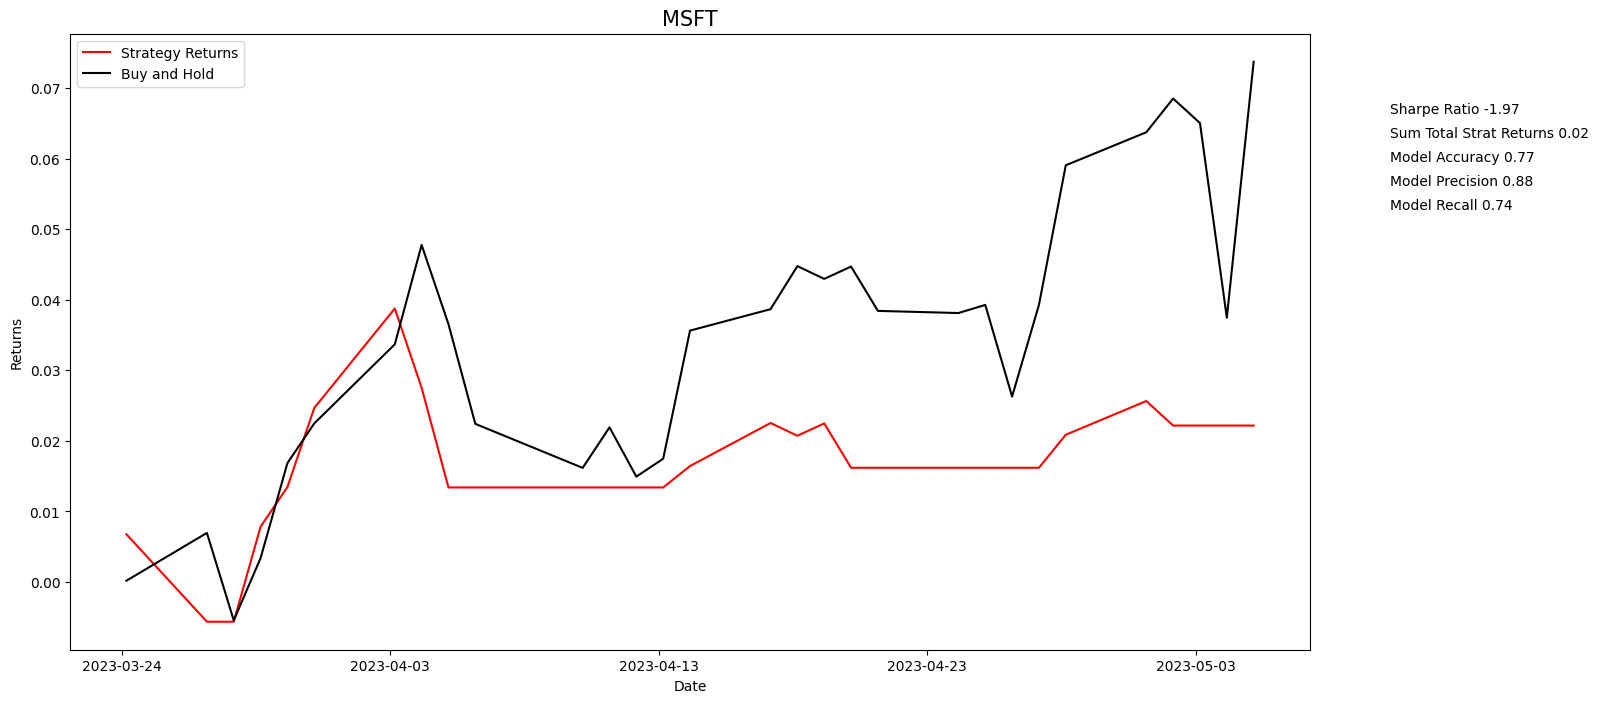

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16, 8
                                ))

ax.plot(df[-30:].index.values, df['Total Strat Returns'][-30:].values, color='r', label="Strategy Returns")
ax.plot(df[-30:].index.values, df['Market Returns'][-30:].values, color='k', label="Buy and Hold")

ax.set(xlabel= "Date",ylabel="Returns")
plt.title('MSFT',fontsize=15)
ax.xaxis.set_major_locator(ticker.AutoLocator())

plt.figtext(.95,0.78, s="Sharpe Ratio "+'-1.97')
plt.figtext(.95,0.75, s="Sum Total Strat Returns "+'0.02')
plt.figtext(.95,0.72,s="Model Accuracy " +'0.77')
plt.figtext(.95,0.69,s="Model Precision " +'0.88')
plt.figtext(.95,0.66,s="Model Recall " +'0.74')

plt.legend(loc='best')
plt.show()